### Notebook Imports

In [20]:
import requests
import time
from newspaper import Article

import pandas as pd
import concurrent.futures
import datetime

from transformers import pipeline

import gc
import torch
gc.collect()
torch.cuda.empty_cache()

month_dict = {
    'January': '01', 'February': '02', 'March': '03', 'April': '04', 'May': '05', 
    'June': '06', 'July': '07', 'August': '08', 'September': '09', 'October': '10', 
    'November': '11', 'December': '12' 
}

short_month_dict = {
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 
    'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12' 
}


### https://climate.mit.edu/news Rate(0.2 sec/article)

In [6]:
def scrape_mit(n_articles = 10):
    links_mit = []

    n_actual = 0
    k = 0
    while n_actual <= n_articles:
        URL_mit = "https://climate.mit.edu/news?sort_bef_combine=created_DESC&sort_by=created&sort_order=DESC&page=" + str(k)
        page_mit = requests.get(URL_mit)
        soup_mit = BeautifulSoup(page_mit.content, "html.parser")
        results_mit = soup_mit.find_all(class_="field-group-link card-link")
        k += 1


        for i in results_mit:
            try: 
                if ( i.find(class_="pseudo-author").get_text() == "MIT News"):
                    link = i['href']
                    links_mit.append("https://climate.mit.edu" + link)
                    n_actual += 1
            except:
                continue
        
    data_mit = pd.DataFrame(columns=['title', 'content', 'date'])

    def fetch(url):
        response = requests.get(url)
        return response.content

    def convert_date(date):
        date = date.split(" ")
        day = date[1].replace(",", "")
        month = date[0]
        year = date[2]
        month = month_dict[month]
        return year + "-" + month + "-" + day

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(fetch, links_mit[:n_articles]))

    for i in range(n_articles):
        article_soup = BeautifulSoup(results[i], "html.parser")
        title = article_soup.find(class_='faux-full-title').get_text()
        date = article_soup.find(class_='type-date').get_text().replace("\n", " ").replace("\xa0", "")
        date = convert_date(date)
        content = article_soup.find(class_='clearfix text-formatted field field--name-body field--type-text-with-summary field--label-hidden field__item').get_text().replace("\n", " ").replace("\xa0", "")
        #content = summarizer(content)[0]['summary_text']
        data_mit = pd.concat([data_mit, pd.DataFrame({'title': [title], 'content': [content], 'date': [date], 'source': ["MIT"], 'url': [links_mit[i]]})], ignore_index=True)

    return data_mit

### https://www.iea.org/news (Rate: 0.2sec/article)

In [7]:
def scrape_iea(n_articles = 10):
    n_pages = n_articles // 24 + 1
    links_iea = []

    for i in range(1, n_pages+1):
        URL_iea = "https://www.iea.org/news?page=" + str(i)
        page_iea = requests.get(URL_iea)
        soup_iea = BeautifulSoup(page_iea.content, "html.parser")
        results_iea = soup_iea.find_all("article")

        for i in results_iea:
            link = i.find('a')['href']
            links_iea.append("https://www.iea.org/" + link)
        
    data_iea = pd.DataFrame(columns=['title', 'content', 'date'])

    def fetch(url):
        response = requests.get(url)
        return response.content

    def convert_date(date):
        date = date.split(" ")
        day = date[0]
        month = date[1]
        year = date[2]
        month = month_dict[month]
        return year + "-" + month + "-" + day

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(fetch, links_iea[:n_articles]))

    for i in range(n_articles):
        article_soup = BeautifulSoup(results[i], "html.parser")
        print(article_soup.find(class_='o-page__img').find('img')['data-src'])
        title = article_soup.find(class_='o-hero-freepage__title f-title-3').get_text()
        date = article_soup.find(class_='o-hero-freepage__meta').get_text().replace("\n", " ").replace("\xa0", "")
        date = convert_date(date)
        content = article_soup.find(class_='m-block m-block--text').get_text().replace("\n", " ").replace("\xa0", "")
        image = article_soup.find(class_='o-page__img')
        data_iea = pd.concat([data_iea, pd.DataFrame({'title': [title], 'content': [content], 'date': [date], 'source': ["IEA"], 'url': [links_iea[i]], 'image': [image]})], ignore_index=True)

    return data_iea

In [8]:
data_iea = scrape_iea(10)

https://iea.imgix.net/e497e5d1-6811-45e5-8492-7e5aff4bf3b5/GettyImages-1310488699.jpg?auto=compress%2Cformat&fit=min&q=80&rect=0%2C500%2C6000%2C3375&w=1220&h=686&fit=crop&fm=jpg&q=70&auto=format
https://iea.imgix.net/96c7a302-e12b-4c33-8ef0-363031af376e/Hydrogenpatentsforacleanenergyfuture.png?auto=compress%2Cformat&fit=min&q=80&rect=0%2C394%2C797%2C448&w=1220&h=686&fit=crop&fm=jpg&q=70&auto=format
https://iea.imgix.net/76d952f4-905c-4b3a-912c-f000111b2947/IEA-Fatih-Birol-Japan-Fumio-Kishida.png?auto=compress%2Cformat&fit=min&q=80&rect=0%2C0%2C1920%2C1080&w=1220&h=686&fit=crop&fm=jpg&q=70&auto=format
https://iea.imgix.net/742abe56-1916-4aa6-a78d-cd4bf955d73a/GettyImages-166068815.jpg?auto=compress%2Cformat&fit=min&q=80&rect=0%2C436%2C4200%2C2364&w=1220&h=687&fit=crop&fm=jpg&q=70&auto=format
https://iea.imgix.net/76e3e533-96ef-4998-ac6d-ee723a3a4b6f/clark-van-der-beken-efUMPOZba2I-unsplash.jpg?auto=compress%2Cformat&fit=min&q=80&rect=0%2C91%2C4880%2C2743&w=1220&h=686&fit=crop&fm=jpg&q=7

In [9]:
data_iea

,title,content,date,source,url,image
0,The world is entering a new age of clean techn...,The energy world is at the dawn of a new ind...,2023-01-12,IEA,https://www.iea.org//news/the-world-is-enterin...,"[\n, [], \n]"
1,Hydrogen patents indicate shift towards clean ...,Hydrogen technology development is shifting ...,2023-01-10,IEA,https://www.iea.org//news/hydrogen-patents-ind...,"[\n, [], \n]"
2,Executive Director meets with Prime Minister F...,IEA Executive Director Faith Birol had a bil...,2023-01-09,IEA,https://www.iea.org//news/executive-director-m...,"[\n, [], \n]"
3,The world’s coal consumption is set to reach a...,Global coal demand is set to increase only m...,2022-12-16,IEA,https://www.iea.org//news/the-world-s-coal-con...,"[\n, [], \n]"
4,How the European Union can avoid natural gas s...,The European Union faces a potential shortfa...,2022-12-12,IEA,https://www.iea.org//news/how-the-european-uni...,"[\n, [], \n]"
5,IEA and Ukraine deepen bilateral cooperation w...,The IEA and Ukraine today signed a two-year ...,2022-12-12,IEA,https://www.iea.org//news/iea-and-ukraine-deep...,"[\n, [], \n]"
6,Global government spending on clean energy tra...,Global government spending to support clean ...,2022-12-09,IEA,https://www.iea.org//news/global-government-sp...,"[\n, [], \n]"
7,Renewable power’s growth is being turbocharged...,The global energy crisis is driving a sharp ...,2022-12-06,IEA,https://www.iea.org//news/renewable-power-s-gr...,"[\n, [], \n]"
8,Global energy efficiency progress is accelerat...,Energy efficiency actions have accelerated g...,2022-12-02,IEA,https://www.iea.org//news/global-energy-effici...,"[\n, [], \n]"
9,The global energy crisis is driving a surge in...,Worldwide sales of heat pumps are set to soa...,2022-11-30,IEA,https://www.iea.org//news/the-global-energy-cr...,"[\n, [], \n]"


### https://www.rechargenews.com/latest (Rate: 0.2sec/article)

In [10]:
def scrape_rn(n_articles = 10):
    n_pages = n_articles // 20 + 1
    links_rn = []

    for i in range(1, n_pages+1):
        URL_rn = "https://www.rechargenews.com/latest?page=" + str(i)
        page_rn = requests.get(URL_rn)
        soup_rn = BeautifulSoup(page_rn.content, "html.parser")
        results_rn = soup_rn.find_all(class_="teaser-body-image")

        for i in results_rn:
            link = i.find('a')['href']
            links_rn.append("https://www.rechargenews.com" + link)
        
    data_rn = pd.DataFrame(columns=['title', 'content', 'date'])

    def fetch(url):
        response = requests.get(url)
        return response.content

    def convert_date(date):
        date = date.split(" ")
        day = date[3]
        month = date[4]
        year = date[5]
        month = month_dict[month]
        return year + "-" + month + "-" + day

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(fetch, links_rn[:n_articles]))

    for i in range(n_articles):
        try:
            article_soup = BeautifulSoup(results[i], "html.parser")
            title = article_soup.find(class_='fs-xxl fw-bold mb-4 article-title ff-sueca-bold').get_text().replace("\n", " ").replace("\xa0", "")
            date = article_soup.find(class_='pr-3').get_text().replace("\n", " ").replace("\xa0", "")
            date = convert_date(date)
            image =  article_soup.find("figure").find("img")['src']
            content = article_soup.find(class_='article-body').get_text().replace("\n", " ").replace("\xa0", "")
        #content = summarizer(content)[0]['summary_text']
    
        except:
            continue
        data_rn = pd.concat([data_rn, pd.DataFrame({'title': [title], 'content': [content], 'date': [date], 'source': ["Recharge News"], 'url': [links_rn[i]], 'image': [image]})], ignore_index=True)

    return data_rn

In [11]:
data = scrape_rn()

In [12]:
data

,title,content,date,source,url,image
0,Orsted plans massive offshore wind build to...,Orsted has applied for permits to build four a...,2023-01-16,Recharge News,https://www.rechargenews.com/wind/orsted-plans...,https://images-global.nhst.tech/image/SlNQTHh2...
1,'Urgent and targeted' | Irena chief La Came...,The International Renewable Energy Agency (Ire...,2023-01-16,Recharge News,https://www.rechargenews.com/energy-transition...,https://images-global.nhst.tech/image/THRWMjky...
2,World 'way off track' for Paris climate goa...,The world is “way off track” to meet the clima...,2023-01-15,Recharge News,https://www.rechargenews.com/energy-transition...,https://images-global.nhst.tech/image/cytUSWQz...
3,India plans 8GW a year of wind auctions to ...,India will auction about 8GW of projects annua...,2023-01-15,Recharge News,https://www.rechargenews.com/wind/india-plans-...,https://images-global.nhst.tech/image/dkw4VGpL...
4,Shell-EDF sign on for New Jersey Wind Port ...,The Shell-EDF joint venture (JV) behind the At...,2023-01-14,Recharge News,https://www.rechargenews.com/solar/shell-edf-s...,https://images-global.nhst.tech/image/UmZsUzJq...
5,Green giant Orsted presses go on largest so...,Orsted confirmed a final investment decision (...,2023-01-13,Recharge News,https://www.rechargenews.com/energy-transition...,https://images-global.nhst.tech/image/UmZsUzJq...
6,"US offshore winds of change, revolutions in...",US offshore wind this week saw the departure o...,2023-01-13,Recharge News,https://www.rechargenews.com/energy-transition...,https://images-global.nhst.tech/image/VEEwVjFJ...
7,UK needs 'onshore wind and solar revolution...,The UK should set clear roadmaps for an onshor...,2023-01-13,Recharge News,https://www.rechargenews.com/energy-transition...,https://images-global.nhst.tech/image/L0h2L0JU...
8,'Red flag for green power' | South Korea sl...,South Korea was accused of snubbing the needs ...,2023-01-13,Recharge News,https://www.rechargenews.com/energy-transition...,https://images-global.nhst.tech/image/THVqWlZ4...
9,China's Mingyang looks 'beyond 18MW' with 1...,Mingyang Smart Energy set out its stall to tak...,2023-01-13,Recharge News,https://www.rechargenews.com/wind/chinas-mingy...,https://images-global.nhst.tech/image/RGRIWTVw...


### https://www.euronews.com/tag/energy (Rate: 0.2sec/article)

In [13]:
def scrape_en(n_articles = 10):
    n_pages = n_articles // 20 + 1
    links_en = []

    for i in range(1, n_pages+1):
        URL_en = "https://www.euronews.com/tag/energy?p=" + str(i)
        page_en = requests.get(URL_en)
        soup_en = BeautifulSoup(page_en.content, "html.parser")
        results_en = soup_en.find_all(class_="m-object__title qa-article-title")

        for i in results_en:
            link = i.find('a')['href']
            links_en.append("https://www.euronews.com" + link)
        
    data_en = pd.DataFrame(columns=['title', 'content', 'date'])

    def fetch(url):
        response = requests.get(url)
        return response.content

    def convert_date(date):
        date = date.split(":")
        date[1] = date[1].split(" ")
        date[1] = date[1][0]
        day = date[1].split("/")[0]
        month = date[1].split("/")[1]
        year = date[1].split("/")[2]
        return year + "-" + month + "-" + day

    results = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for url in links_en[:n_articles]:
            future = executor.submit(fetch, url)
            results.append(future)
    results = [future.result() for future in results]

    for i in range(n_articles):
        try:
            article_soup = BeautifulSoup(results[i], "html.parser")
            for script in article_soup(["script", "style"]):
                script.decompose()
            title = article_soup.find(class_='c-article-title').get_text().replace("\n", " ").replace("\xa0", "")
            date = article_soup.find(class_='c-article-date').get_text().replace("\n", " ").replace("\xa0", "")
            date = convert_date(date)
            content = article_soup.find(class_='js-responsive-iframes-container').get_text().replace("\n", " ").replace("\xa0", "")
        except:
            continue
        # with torch.no_grad():
        #     content = summarizer(content)[0]['summary_text']
        data_en = pd.concat([data_en, pd.DataFrame({'title': [title], 'content': [content], 'date': [date], 'source': ["Euronews"], 'url': [links_en[i]]})], ignore_index=True)

    return data_en

### https://mercomindia.com/archive/ (0.1 sec/article)

In [14]:
def scrape_mi(n_articles = 10):
    n_pages = n_articles // 5 + 1
    links_mi = []

    for i in range(1, n_pages+1):
        URL_mi = "https://mercomindia.com/archive/page-" + str(i)
        page_mi = requests.get(URL_mi)
        soup_mi = BeautifulSoup(page_mi.content, "html.parser")
        results_mi = soup_mi.find_all(class_="pt-cv-title")

        for i in results_mi:
            link = i.find('a')['href']
            links_mi.append(link)
        
    data_mi = pd.DataFrame(columns=['title', 'content', 'date'])

    def fetch(url):
        response = requests.get(url)
        return response.content

    def convert_date(date):
        date = date.split(" ")
        day = date[2].replace(",", "")
        month = date[1]
        year = date[3]
        month = short_month_dict[month]
        return year + "-" + month + "-" + day

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(fetch, links_mi[:n_articles]))

    for i in range(n_articles):
        article_soup = BeautifulSoup(results[i], "html.parser")
        title = article_soup.find("div", {"id": "page-title-text"}).get_text().replace("\n", " ").replace("\xa0", "")
        date = article_soup.find(class_='entry-date').get_text().replace("\n", " ").replace("\xa0", "")
        date = convert_date(date)
        content = article_soup.find(class_='entry-content').get_text().replace("\n", " ").replace("\xa0", "").split("Listen to this article ")[1]
        #content = summarizer(content)[0]['summary_text']
        data_mi = pd.concat([data_mi, pd.DataFrame({'title': [title], 'content': [content], 'date': [date], 'source': ["Mercom India"], 'url': [links_mi[i]]})], ignore_index=True)

    return data_mi

In [15]:
def main(n_articles_per_source):
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        
        data_mit = executor.submit(scrape_mit, n_articles_per_source)
        data_iea = executor.submit(scrape_iea, n_articles_per_source)
        data_rn = executor.submit(scrape_rn, n_articles_per_source)
        data_en = executor.submit(scrape_en, n_articles_per_source)
        data_mi = executor.submit(scrape_mi, n_articles_per_source)

        
        data_mit = data_mit.result()
        data_iea = data_iea.result()
        data_rn = data_rn.result()
        data_en = data_en.result()
        data_mi = data_mi.result()

    data = pd.concat([data_mit, data_iea, data_rn, data_en, data_mi], ignore_index=True)
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(by=['date'], ascending=False)
    return data

In [16]:
data = main(10)
data

https://iea.imgix.net/e497e5d1-6811-45e5-8492-7e5aff4bf3b5/GettyImages-1310488699.jpg?auto=compress%2Cformat&fit=min&q=80&rect=0%2C500%2C6000%2C3375&w=1220&h=686&fit=crop&fm=jpg&q=70&auto=format
https://iea.imgix.net/96c7a302-e12b-4c33-8ef0-363031af376e/Hydrogenpatentsforacleanenergyfuture.png?auto=compress%2Cformat&fit=min&q=80&rect=0%2C394%2C797%2C448&w=1220&h=686&fit=crop&fm=jpg&q=70&auto=format
https://iea.imgix.net/76d952f4-905c-4b3a-912c-f000111b2947/IEA-Fatih-Birol-Japan-Fumio-Kishida.png?auto=compress%2Cformat&fit=min&q=80&rect=0%2C0%2C1920%2C1080&w=1220&h=686&fit=crop&fm=jpg&q=70&auto=format
https://iea.imgix.net/742abe56-1916-4aa6-a78d-cd4bf955d73a/GettyImages-166068815.jpg?auto=compress%2Cformat&fit=min&q=80&rect=0%2C436%2C4200%2C2364&w=1220&h=687&fit=crop&fm=jpg&q=70&auto=format
https://iea.imgix.net/76e3e533-96ef-4998-ac6d-ee723a3a4b6f/clark-van-der-beken-efUMPOZba2I-unsplash.jpg?auto=compress%2Cformat&fit=min&q=80&rect=0%2C91%2C4880%2C2743&w=1220&h=686&fit=crop&fm=jpg&q=7

,title,content,date,source,url,image
21,'Urgent and targeted' | Irena chief La Came...,The International Renewable Energy Agency (Ire...,2023-01-16,Recharge News,https://www.rechargenews.com/energy-transition...,https://images-global.nhst.tech/image/THRWMjky...
39,Daily News Wrap-Up: L&T Partners with H2Carrie...,Here are some noteworthy clean...,2023-01-16,Mercom India,https://mercomindia.com/daily-news-wrap-up-lt-...,NaN
20,Orsted plans massive offshore wind build to...,Orsted has applied for permits to build four a...,2023-01-16,Recharge News,https://www.rechargenews.com/wind/orsted-plans...,https://images-global.nhst.tech/image/SlNQTHh2...
22,World 'way off track' for Paris climate goa...,The world is “way off track” to meet the clima...,2023-01-15,Recharge News,https://www.rechargenews.com/energy-transition...,https://images-global.nhst.tech/image/cytUSWQz...
23,India plans 8GW a year of wind auctions to ...,India will auction about 8GW of projects annua...,2023-01-15,Recharge News,https://www.rechargenews.com/wind/india-plans-...,https://images-global.nhst.tech/image/dkw4VGpL...
24,Shell-EDF sign on for New Jersey Wind Port ...,The Shell-EDF joint venture (JV) behind the At...,2023-01-14,Recharge News,https://www.rechargenews.com/solar/shell-edf-s...,https://images-global.nhst.tech/image/UmZsUzJq...
30,Gas pipeline explosion in Lithuan...,An explosion in a gas pipeline in central Lith...,2023-01-14,Euronews,https://www.euronews.com/2023/01/14/gas-pipeli...,NaN
40,Solar PV Soiling Likely to Cut 4-5% of Energy ...,The soiling of solar photovolt...,2023-01-13,Mercom India,https://mercomindia.com/solar-pv-soiling-cut-e...,NaN
31,Gas pipeline explodes in Lithuani...,"A gas pipeline has exploded in Lithuania, acco...",2023-01-13,Euronews,https://www.euronews.com/2023/01/13/gas-pipeli...,NaN
41,"Kerala’s ANERT Invites Bids to Procure 1,000 S...",The Agency for New & Renewable...,2023-01-13,Mercom India,https://mercomindia.com/keralas-anert-bids-pro...,NaN


In [17]:
articles = data['content'].tolist()

In [18]:
from transformers import BartTokenizer,BartForConditionalGeneration, pipeline
model=BartForConditionalGeneration.from_pretrained('Yale-LILY/brio-cnndm-uncased')
tokenizer=BartTokenizer.from_pretrained('Yale-LILY/brio-cnndm-uncased')
summarizer=pipeline("summarization",model=model,tokenizer=tokenizer,batch_size=16,truncation=True,device=0)

In [19]:
summarizer(articles[0], min_length=120, do_sample=False)

[{'summary_text': "International Renewable Energy Agency appoints Francesco La Camera as director-general for a second four-year term. La Camera has led the peak intergovernmental body for renewables since 2019. Irena says it will adopt a new strategy based on 'urgent and targeted action' to push green supply sources into the global energy mainstream in 2027. The body will stress on issues such as a 'just transition' and 'universal access' to renewable energy in a new direction for the agency.    the body has appointed a new five-year strategy for the renewable energy agency."}]

In [38]:
def scrape_netl(n_articles = 4):
    n_pages = n_articles // 20 + 1
    links_netl = []

    for i in range(1, n_pages+1):
        URL_netl = "https://netl.doe.gov/news-room-news-stories?tid=All&year=All&page=" + str(i-1)
        page_netl = requests.get(URL_netl)
        soup_netl = BeautifulSoup(page_netl.content, "html.parser")
        results_netl = soup_netl.find_all(class_="field-content dcorner-title")

        for i in results_netl:
            link = i.find('a')['href']
            links_netl.append("https://netl.doe.gov" + link)
        
    data_netl = pd.DataFrame(columns=['title', 'content', 'date'])

    def fetch(url):
        response = requests.get(url)
        return response.content

    def convert_date(date):
        date = date.split(" ")
        print(date)
        day = date[3].replace(",", "")
        month = date[2]
        year = date[4]
        month = month_dict[month]
        return year + "-" + month + "-" + day

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(fetch, links_netl[:n_articles]))

    for i in range(n_articles):
        article_soup = BeautifulSoup(results[i], "html.parser")
        title = article_soup.find(class_='h2 story-title').get_text().replace("\n", " ").replace("\xa0", "")
        date = article_soup.find(class_='post-date2').get_text().replace("\n", " ").replace("\xa0", "")
        date = convert_date(date)
        content = article_soup.find(class_='story-text').get_text().replace("\n", " ").replace("\xa0", "")
        image = "https://netl.doe.gov" + article_soup.find(class_='story-hero-image').find('img')['src']
        data_netl = pd.concat([data_netl, pd.DataFrame({'title': [title], 'content': [content], 'date': [date], 'source': ["netl"], 'url': [links_netl[i]], 'image': [image]})], ignore_index=True)

    return data_netl

In [39]:
data = scrape_netl(4)

['', '', 'January', '09,', '2023', '']
['', '', 'January', '09,', '2023', '']
['', '', 'January', '05,', '2023', '']
['', '', 'December', '21,', '2022', '']


In [40]:
data

,title,content,date,source,url,image
0,NETL Contractor to Receive Rookie of the Year...,An NETL specialist whose work significantly r...,2023-01-09,netl,https://netl.doe.gov/node/12269,https://netl.doe.gov/sites/default/files/style...
1,NETL-Developed Online Database Brings Energy-...,"In the above image, NETL’s Nicholas Siefert (...",2023-01-09,netl,https://netl.doe.gov/node/12268,https://netl.doe.gov/sites/default/files/style...
2,Two NETL Employees Named Oppenheimer Fellows ...,A pair of NETL employees — Alexandra “Ale” Ha...,2023-01-05,netl,https://netl.doe.gov/node/12266,https://netl.doe.gov/sites/default/files/style...
3,NETL-Supported Projects Seek to Convert Flare...,"Often, bright orange flames can be seen danci...",2022-12-21,netl,https://netl.doe.gov/node/12258,https://netl.doe.gov/sites/default/files/style...


In [45]:
page = requests.get("http://localhost:3000/")
soup = BeautifulSoup(page.content, "html.parser")
soup

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="#000000" name="theme-color"/>
<title>Energy Feed</title>
<script defer="" src="/static/js/bundle.js"></script></head>
<body>
<noscript>You need to enable JavaScript to run this app.</noscript>
<div id="root"></div>
</body>
</html>

In [6]:
import concurrent.futures
from newspaper import Article

google_news = requests.get("https://news.google.com/rss/search?q=energy%20carbon+&hl=en-US&gl=US&ceid=US%3Aen")
soup = BeautifulSoup(google_news.content, "html.parser")

google_feeds = []


for i in soup.find_all('item'):
    try:
        feed = {
            'title' : i.find('title').get_text(),
            'url' : i.find('description').get_text().split('href="')[1].split('"')[0],
            'date' : i.find('pubdate').get_text(),
            'image' : None,
            'content' : None,
            'source' : i.get_text().split('</font>')[1] + " via Google News"
        }
        google_feeds.append(feed)
    except:
        pass

def download_article(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        print(article.publish_date)
        return [article.text, article.top_image]
    except:
        pass

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(download_article, [i['url'] for i in google_feeds]))

pos = 0
for i in google_feeds:
    if results[pos] is None:
        google_feeds.remove(i)
    else:
        i['content'] = results[pos][0]
        i['image'] = results[pos][1]
        pos+=1

/home/d3v/anaconda3/envs/pytorch/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


None
None
None
2023-01-10 11:15:00+00:00
2023-01-10 09:00:09+00:00
2023-01-16 10:59:00+00:00
2023-01-14 14:07:45+00:00
None
None
None
2023-01-15 07:25:52+00:00
2023-01-16 11:59:13+00:00
None
2023-01-16 16:04:04+00:00
None
2022-12-22 11:00:00+00:00
2023-01-16 10:18:52+00:00
2023-01-11 14:53:00+00:00
2023-01-13 07:42:50+00:00
2023-01-15 00:00:00-06:00
None
2023-01-12 12:00:31+00:00
2023-01-16 04:24:29+00:00
None
None
None
2023-01-16 00:01:50+00:00
None
2023-01-11 08:00:00+00:00
2023-01-16 11:50:00
None
2023-01-16 06:27:00+00:00
None
None
2022-10-17 18:52:21+05:30
2023-01-16 16:43:32+09:00
None
2023-01-15 11:52:22+00:00
None
None
None
2023-01-11 14:45:00.303000+00:00
2023-01-16 10:53:16+02:00
2023-01-12 09:59:00+00:00
2023-01-15 14:54:37-08:00
None
None
None
2023-01-16 12:55:24+00:00
None
2023-01-16 14:00:00
2023-01-16 08:30:00
None
None
None
2023-01-16 12:31:42+00:00
2023-01-16 11:52:41+00:00
None
2023-01-16 12:46:17+00:00
None
None
None
None
None
None
None
None
None
2023-01-16 12:53:00+

In [4]:
google_feeds

[{'title': 'In Virginia, carbon emissions drop as data centers boom, thanks to RGGI pact - Energy News Network',
  'url': 'https://news.google.com/__i/rss/rd/articles/CBMibGh0dHBzOi8vZW5lcmd5bmV3cy51cy8yMDIzLzAxLzE2L2luLXZpcmdpbmlhLWNhcmJvbi1lbWlzc2lvbnMtZHJvcC1hcy1kYXRhLWNlbnRlcnMtYm9vbS10aGFua3MtdG8tcmdnaS1wYWN0L9IBbGh0dHBzOi8vZW5lcmd5bmV3cy51cy8yMDIzLzAxLzE2L2luLXZpcmdpbmlhLWNhcmJvbi1lbWlzc2lvbnMtZHJvcC1hcy1kYXRhLWNlbnRlcnMtYm9vbS10aGFua3MtdG8tcmdnaS1wYWN0Lw?oc=5',
  'date': 'Mon, 16 Jan 2023 10:59:00 GMT',
  'image': 'https://i0.wp.com/energynews.us/wp-content/uploads/2023/01/pexels-brett-sayles-5480781-1.jpg?fit=1280%2C852&ssl=1',
  'content': 'Virginia’s participation in an East Coast greenhouse gas emissions pact is pivotal to curbing the climate impact of its thriving data center industry.\n\nGlobally, northern Virginia has become one of the largest data center hubs over the last decade-plus. Offering generous tax incentives has attracted tech giants eager to construct massive 

In [13]:
feed = {
    'title' : google_feeds[0].find('title').get_text(),
    'url' : google_feeds[0].find('description').get_text().split('href="')[1].split('"')[0],
    'date' : google_feeds[0].find('pubdate').get_text(),
}

[]

In [20]:
feeds = soup.find_all('item')

In [30]:
feeds[0].get_text().split('</font>')[1]

'Energy News Network'

In [19]:
google_feeds[0]

{'title': 'In Virginia, carbon emissions drop as data centers boom, thanks to RGGI pact - Energy News Network',
 'url': 'https://news.google.com/__i/rss/rd/articles/CBMibGh0dHBzOi8vZW5lcmd5bmV3cy51cy8yMDIzLzAxLzE2L2luLXZpcmdpbmlhLWNhcmJvbi1lbWlzc2lvbnMtZHJvcC1hcy1kYXRhLWNlbnRlcnMtYm9vbS10aGFua3MtdG8tcmdnaS1wYWN0L9IBbGh0dHBzOi8vZW5lcmd5bmV3cy51cy8yMDIzLzAxLzE2L2luLXZpcmdpbmlhLWNhcmJvbi1lbWlzc2lvbnMtZHJvcC1hcy1kYXRhLWNlbnRlcnMtYm9vbS10aGFua3MtdG8tcmdnaS1wYWN0Lw?oc=5',
 'date': 'Mon, 16 Jan 2023 10:59:00 GMT',
 'image': 'https://i0.wp.com/energynews.us/wp-content/uploads/2023/01/pexels-brett-sayles-5480781-1.jpg?fit=1280%2C852&ssl=1',
 'content': 'Virginia’s participation in an East Coast greenhouse gas emissions pact is pivotal to curbing the climate impact of its thriving data center industry.\n\nGlobally, northern Virginia has become one of the largest data center hubs over the last decade-plus. Offering generous tax incentives has attracted tech giants eager to construct massive serve

In [31]:
for i in google_feeds:
    try:
        article = Article(i['link'])
        article.download()
        article.parse()
        i['content'] = article.text
    except:
        pass

In [33]:
#check if how many articles have content
len([i for i in google_feeds if 'content' in i])

92

In [44]:
#use newspaper3k multi-threading to download articles from google_feeds list
from newspaper import fulltext

import concurrent.futures
from newspaper import Article

def download_article(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text
    except:
        pass

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(download_article, [i['link'] for i in google_feeds]))



IndexError: list index out of range

In [42]:
len(google_feeds)

99

In [39]:
results

[None,
 'On December 30, 2022, the North Carolina Utilities Commission issued its long-awaited order in the Duke Energy Carbon Plan proceeding. By unreasonably limiting Duke’s near-term procurement of clean, low-cost solar resources, the Commission’s order will increase costs for ratepayers and delay reductions in Duke’s carbon emissions.\n\nUnder landmark legislation passed by the North Carolina General Assembly in 2021, the Commission was required to adopt a plan for reducing Duke’s North Carolina carbon emissions by 70% (against 2005 levels) by 2030, unless the deadline is extended by the Commission under certain allowable circumstances.\n\nLast May, Duke filed a proposed Carbon Plan. It included several portfolios for achieving the required carbon reductions, but only one that would do so by 2030. Interested parties, including renewable energy suppliers, customer groups, environmental organizations, the North Carolina Attorney General, and the state’s consumer advocate, filed thous

In [59]:
from bs4 import BeautifulSoup
import requests
import time
import concurrent.futures
start=time.time()
def scrape_eng(n_articles=10):
    n_pages=n_articles//11 +1
    links_eng=[]
    for i in range(0,n_pages):
        url_gov='https://www.energy.gov/fecm/listings/fecm-press-releases-and-techlines?page='+str(i)
        page_gov=requests.get(url_gov)
        soup_gov=BeautifulSoup(page_gov.content,'lxml')
        results_gov=soup_gov.find_all(class_='search-result-title')
        links = soup_gov.find_all(class_='search-result-title')
        print(soup_gov.find_all(class_='search-result-title')[0]['href'])
        for i in links:
            link=i['href']

            links_eng.append('https://www.energy.gov/articles/'+link)
    
    def fetch(url):
        response=requests.get(url).content
        article_soup = BeautifulSoup(response, "html.parser")
        title=article_soup.find(class_='page-title').get_text()
        date=article_soup.find(class_='page-hero-date').get_text()
        content=article_soup.find('div').get_text()
        return {'content': content}

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results=list(executor.map(fetch,links_eng[:n_articles]))
    return results

In [60]:
scrape_eng(4)

/fecm/articles/doe-invests-25-million-support-university-training-and-research-decarbonization-and


AttributeError: 'NoneType' object has no attribute 'get_text'

In [30]:
import requests
from lxml import html
from bs4 import BeautifulSoup

def yahoo_news_source(query, params={}):
    feed = "https://news.search.yahoo.com/search"
    params['p'] = query
    fq = requests.get(feed, params=params)
    soup = BeautifulSoup(fq.content, "html.parser")
    articles = soup.find_all("div", class_="NewsArticle")
    return articles

In [31]:
data = yahoo_news_source("energy carbon")

<!DOCTYPE html>
<html class="NoJs" id="atomic" lang="en-US"><head><meta content="on" http-equiv="x-dns-prefetch-control"/><meta content="text/html; charset=utf-8" http-equiv="content-type"/><link href="https://s.yimg.com/pv/static/img/y_icon_iphone_76.min.png" rel="apple-touch-icon" sizes="76x76"/><link href="https://s.yimg.com/pv/static/img/y_icon_iphone_114.min.png" rel="apple-touch-icon" sizes="114x114"/><link href="https://s.yimg.com/pv/static/img/y_icon_iphone_120.min.png" rel="apple-touch-icon" sizes="120x120"/><meta content="origin" name="referrer"/><meta content="width=device-width, initial-scale=1.0" name="viewport"/><meta content="guce.yahoo.com" name="oath:guce:consent-host"><noscript><meta content="0;url=https://news.search.yahoo.com/search?p=energy+carbon&amp;ei=UTF-8&amp;nojs=1" http-equiv="refresh"/></noscript><script nonce="WdsyB2z+KIjMU8KGhI5q4w==" type="text/javascript">Array.prototype.indexOf||(Array.prototype.indexOf=function(r,t){"use strict";var e;if(null==this)th
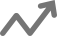
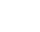
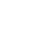
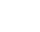
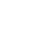

In [32]:
data